# Automatic Differentiation in Topology Optimization using Julia Language

## 1. Problem Setup

A standard density-based topology optimization problem is formulated as: Find $\alpha_{\mathrm{opt}}$ such that
$$
\alpha_{\mathrm{opt}} = \;\mathrm{argmin}\; j(u(\alpha)),
$$
where the displacement ${u} = {u}(\alpha) \in V$ satisfies
$$
a(\alpha, {u}, {v}) = l(\alpha, {v}),
$$
for all ${v} \in W$. We are interested in finding the gradient of the objective $j$. 

### 1.1. Adjoint Method

Differentiating (Gateaux derivative) the energy functional we obtain

$$
D\,j(u)[\delta u, \delta \alpha] = \underbrace{D_{u}\,j(u)[\delta u]}_{\text{Term 1}} + \underbrace{D_{\alpha}\,j(u)[\delta \alpha]}_{\text{Term 2}}
$$

- Term 2: Handled using Forward Mode AD ( = 0 in our case)
- __Term 1: Handled using Adjoint Method__

Next, differentiating the weak form, we obtain

$$
D_u\,a(\alpha, u, v)[\delta u] = D_{\alpha}\,l(\alpha, v)[\delta \alpha] - D_{\alpha}\,a(\alpha, u, v)[\delta \alpha]
$$

We are interested in eliminating $\delta u$, so we proceed as follows: Find $\lambda \in W$ such that

$$
D_u\,a(\alpha, u, \lambda)[q] = D_u\,j(u)[q]
$$

for all $q \in W$. This is known as the __adjoint problem__. Recalling the derivative of the weak formulation:

$$
D_u\,a(\alpha, u, v)[\delta u] = D_{\alpha}\,l(\alpha, v)[\delta \alpha] - D_{\alpha}\,a(\alpha, u, v)[\delta \alpha]
$$

Setting $q = \delta u$ in the adjoint problem and $v = \lambda$ in the derivative of the weak formulation we obtain:

$$
\boxed{D_u\,j(u)[\delta u] = D_{\alpha}\,l(\alpha, \lambda)[\delta \alpha] - D_{\alpha}\,a(\alpha, u, \lambda)[\delta \alpha]}
$$

In [114]:
using Gridap
using Gridap.Arrays: lazy_collect

using LinearAlgebra

using DualNumbers
ε = DualNumbers.ε   
using ChainRulesCore
using Zygote

using ProgressMeter, Plots

We construct a simple unit square domain and define the standard P1 finite element spaces containing `Float64` and `Dual128`

In [115]:
domain = (0, 1, 0, 1)
N = (100,100)
model = CartesianDiscreteModel(domain, N)
Ω = Triangulation(model)
dΩ = Measure(Ω,2)

reffe = ReferenceFE(lagrangian, Float64, 1)

# Finite element spaces (Trial and Test)
W = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags=["tag_8"])
V = TrialFESpace(W, 0.0)

# Finite element space (Trial and Test), containing dual numbers
W′ = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags=["tag_8"], 
                    vector_type=Vector{Dual128});
V′ = TrialFESpace(W′, 0.0);

Let us now write the bilinear and linear forms:  I consider the standard heat compliance problem:

- The linear form
$$
  l({u}) = \int_{\Omega} f u\,dx
$$
and the objective function
$$
  j({u}) = \int_{\Omega} {f} {u}\,dx.
$$
- The bilinear form is given by
$$
  a(\alpha, {u}, {v}) = \int_{\Omega} \alpha\, \nabla({u}) \, \cdot \, \nabla({v})\,dx.
$$

In [116]:
f(x) = 1.0;

a(u,v,ρ) = ∫( ρ*(∇(v)⋅∇(u)) )dΩ
l(v,ρ) = ∫(f*v)dΩ;

# Objective
j(u,ρ) = ∫(f*u)dΩ;

### 1.2 Adjoint Method

The derivative of the energy functional is given by

$$
D(j)[\delta \alpha, \delta u] = -a(\delta \alpha, u, \lambda)
$$

where $\lambda$ is the solution to the adjoint problem: Find $\lambda \in W$ s.t

$$
  a(\alpha, q, \lambda) = \int_{\Omega} f q\,dx
$$

for all $q\in W$. 

> We get a special case where $\lambda = u$, if $V = W$.

## 2. Solving the state equation

First, we define a function to solve the state equation.

In [117]:
"""
Function to solve the FEM problem to obtain the state variable
"""
function solve_state(α::AbstractVector{T}) where T<:Real
  a₁(u, v) = a(u, v, α)
  l₁(v) = l(v, α)
  op = AffineFEOperator(a₁, l₁, V, W)
  K = get_matrix(op)
  solve(op), factorize(K)
end;

# Define a random density field.
α = rand(prod(N));

# Testing the function:
p, LHS = solve_state(α);

It is also useful to define the following method for energy.

In [118]:
"""
j as a function of the design alone. 
The state variable is solved inside the function.
"""
function j(α::AbstractVector{T}) where T<:Real
  p, = solve_state(α)
  ∑(j(p, α))
end

methods(j)

# 2 methods for generic function "j" from Main:
 [1] j(α::AbstractVector{T}) where T<:Real
     @ ~/Desktop/TopOpt/TopOptCode/Misc/JuliaTopOpt/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:5
 [2] j(u, ρ)
     @ ~/Desktop/TopOpt/TopOptCode/Misc/JuliaTopOpt/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:7

## 3. Constructing and solving the adjoint problem

- Next, we define a function to solve the adjoint problem. 

- This requires the solution of the state equation along with the derivative of the objective w.r.t to the state variable $\frac{\partial j}{\partial \mathbf{u}}$. 

- We compute $\frac{\partial j}{\partial \mathbf{u}}$ using Forward Mode AD `(DualNumbers.jl)`

- For symmetric problems the LHS of the adjoint problem is the same as the state problem (self-adjoint).

In [119]:
"""
Function to solve the adjoint FEM problem
"""
function solve_adjoint(α::AbstractVector{T}) where T<:Real
  u, K⁻¹ = solve_state(α)
  
  δj(v) = j(u + ε*v, α)
  
  f′ = dualpart.(assemble_vector(δj, W′))
  λ = FEFunction(W, K⁻¹\f′)
  
  u, λ
end;

## Some low-level definitions 

We may get an error if we use the above defined module directly, since `Gridap` does not officially define what it means to multiply a `Dual` and a `Gridap.MultiValue`. 

This ambiguity is expected since a `Dual` is also a `MultiValue` in some sense (think of the field $\mathbb{C}$).

**Defintion of Dual Numbers:**
- We know that the set $\mathbb{C} = (\mathbb{R}^2, +, *)$ is a field under the usual addition and _complex multiplication_ $(a,b)*(c,d) = (ac - bd, \, bc + ad)$. 
- Similarly the set $\mathbb{D} = \left(\mathbb{R}^2\;(\text{or}\, \mathbb{C}^2), +, *\right)$ is a ring under the usual addition and _dual-number multiplication_ $(a,b)*(c,d) = (ac, \,bc + ad)$ (worse than a field, but better than a group...)!

__Problem:__ We do not know how to do $\mathbb{C}^n*\mathbb{D}$.

__Solution:__ `Dual` acts like a scalar.

Let $a \in \mathbb{D}$, $\mathbf{x} \in \mathbb{C}^n$ for some $n \in \mathbb{Z}^+$. We write $x = (x_1, x_2, \cdots, x_n)$ where $x_i \in \mathbb{C}$, and define 

$$
a*\mathbf{x} = (a*x_1, \;a*x_2, \;\cdots, \;a*x_n).
$$

In [120]:
import Base: *
using StaticArrays

"""
Define what it means by the product of a Dual number and MultiValue
"""
function *(z::Dual, p::Gridap.TensorValues.MultiValue)
  S = size(p)
  T = Tuple{S...}
  Gridap.TensorValues.MultiValue(MArray{T}(z .* p.data));
end;
*(p::Gridap.TensorValues.MultiValue, z::Dual) = z * p;

Finally since we chose

```julia
  W = TestFESpace(model, ReferenceFE(lagrangian, Float64, 1), 
                    conformity=:H1, dirichlet_tags=["tag_8"])
  V = TrialFESpace(W, 0.0)
```

we have $V=W$, so $\lambda = u$.

> __Exercise:__ Change $V$ to a non-zero DBC in Slide 5 (or the objective function), and we have $\lambda \ne u$.

In [121]:
u, λ = solve_adjoint(α);

uⱼ = get_cell_dof_values(u);
λⱼ = get_cell_dof_values(λ);

# Checking if the special case holds!
using Test
@show norm(uⱼ - λⱼ)
@test uⱼ ≈ λⱼ

norm(uⱼ - λⱼ) = 1.0146048949984652e-11


Test Passed

## 3. Derivative of the weak formulation w.r.t the design

Next, we write a function to compute the derivative of the weak formulation w.r.t the design $\alpha$.

In this simple case, we compute the element wise inner-product of the bilinear and linear forms in the discrete setting: `Gridap` has a way to do this: 

In [122]:
"""
Function to compute the partial derivatives of the bilinear form 
    a = a(u,v,ρ) and l = l(v,ρ)
w.r.t ρ
"""
function dKdF(α′::AbstractVector{T}) where T<:Dual      
  aₕ(u,v) = a(u, v, α′);  
  lₕ(v) = l(v, α′);

  # Get the cell-wise basis
  w = get_fe_basis(W);
  v = get_trial_fe_basis(V);

  # Get the dualpart of the element stiffness matrix
  dKs = lazy_map(Broadcasting(dualpart), aₕ(v,w)[Ω])
  dFs = lazy_map(Broadcasting(dualpart), lₕ(w)[Ω])
  
  dKs, dFs  
end;

α′ = Dual.(α, 1)
dKdF(α′);

## 4. Putting everything together

Now we are at the final step! The gradient is obtained as follows:

In [123]:
"""
Function to compute the function value and gradient of the objective.
"""
function _j∇j(α::AbstractVector{T}) where T<:Real

  # Partial derivative of the weak formulation w.r.t α.
  α′ = Dual.(α, 1.0)
  dK, dF = dKdF(α′);

  # Solve for the state and adjoint once.
  u, λ = solve_adjoint(α);
  uⱼ = get_cell_dof_values(u);
  λⱼ = get_cell_dof_values(λ);  
  
  # Inner product between the state and adjoint yields the gradient.
  _inner_product(λ, dK, dF, p) = dot(λ,dF) - dot(λ,dK,p);

  val = ∑(j(p,α))
  grad = lazy_collect(lazy_map(_inner_product, λⱼ, dK, dF, uⱼ))
  
  val, grad
end;

## 5. A Reverse Mode ChainRule

Finally, we consolidate the adjoint method as a `ChainRulesCore.rrule`. This tells any Reverse-Mode AD system to use the custom gradient that we define in `_j∇j`

In [124]:
import ChainRulesCore: rrule

"""
Export the adjoint method as a custom reverse-mode rule.
"""
function rrule(::typeof(j), α::AbstractVector{T}) where T<:Real
  val, grad = _j∇j(α)
  function _pullback(Δy)
    Δα = grad * Δy
    println("Picked up _j∇j.")
    NoTangent(), Δα
  end
  val, _pullback
end;

# Zygote.jl is a ReverseMode AD package 
dj, = Zygote.gradient(j, α);

Picked up _j∇j.


Let us use finite difference to check if we obtain the correct gradient.

Our gradient is the exact solution. So, the finite difference gradient should exhibit first order convergence.

In [125]:
"""
Gradient of j using the finite difference (Forward Mode)
"""
function finite_difference(j::Function, α::AbstractVector{Float64}, 
                                Δα::Float64, el::Int)
  δα = zeros(prod(N));
  δα[el] = 1.0
  (j(α+δα*Δα) - j(α))/Δα
end;

"""
Function to compute the error between the exact gradient and FD
"""
function fd_error(j::Function, dj::AbstractVector{Float64}, 
                          α::AbstractVector{Float64}, 
                          Δα::Vector{Float64}, el::Int)
  fd_err = zeros(length(Δα));
  @showprogress for i=1:lastindex(Δα)
    fd_err[i] = abs(finite_difference(j, α, Δα[i], el) - dj[el])
  end
  fd_err
end;

Δα = 10.0 .^(-LinRange(1, 9, 100));

## Example 1:

Testing with 100 different finite different discretization. We see that the gradient converges at first order, before the discretization errors start dominating.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


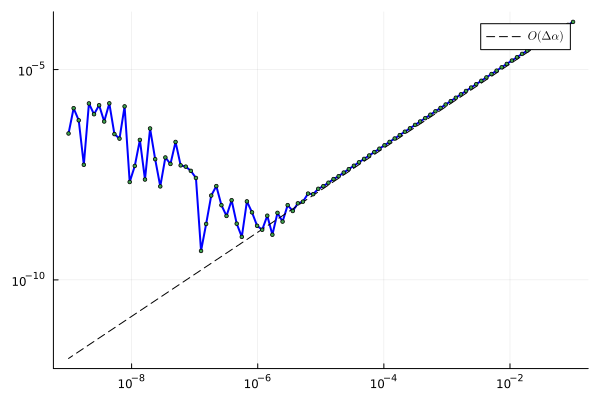

In [126]:
fd_err = fd_error(j, dj, α, Δα, rand(1:prod(N)));

plt1 = Plots.plot()
Plots.plot!(plt1, Δα, fd_err, xaxis=:log10, yaxis=:log10, 
                            label="", lw=2, lc=:blue)
Plots.plot!(plt1, Δα, fd_err[1]/Δα[1]*Δα, label="\$ O(Δα) \$", 
                            lc=:black, ls=:dash)
Plots.scatter!(plt1, Δα, fd_err, label="", markersize=2)

## Example 2:

In this example, we apply a simple function on the density. This is just to check if the chain rule is implemented properly on top of the custom `rrule` we defined.

In [127]:
xᵖ(x; p=3) = @. x^p;

j₁(α::AbstractVector{T}; p=3) where T<:Real = j(xᵖ(α; p=p));

dj₁, = Zygote.gradient(x->j₁(x; p=5), α);

Picked up _j∇j.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


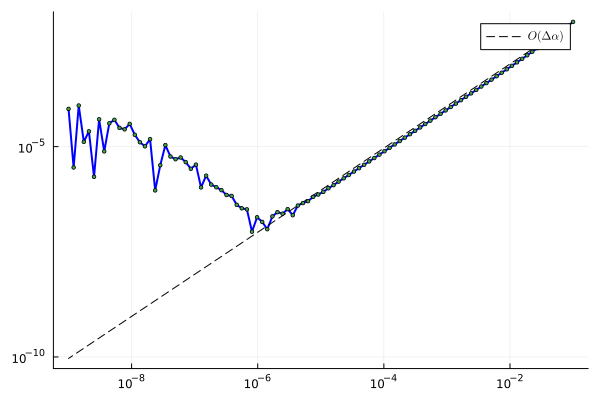

In [128]:
fd_err = fd_error( x->j₁(x; p=5), dj₁, α, Δα, rand(1:prod(N)));

plt1 = Plots.plot()
Plots.plot!(plt1, Δα, fd_err, xaxis=:log10, yaxis=:log10, 
                            label="", lw=2, lc=:blue)
Plots.plot!(plt1, Δα, fd_err[1]/Δα[1]*Δα, label="\$ O(Δα) \$", 
                            lc=:black, ls=:dash)
Plots.scatter!(plt1, Δα, fd_err, label="", markersize=2)

## Example 3:

In this example, we use a filtering operation from the `ImageFiltering` package and define its adjoint. We then define a custom `rrule` using the adjoint.

In [129]:
using ImageFiltering

const R = (3,3);
const ker = Kernel.box(R)*prod(R);
const D⁻¹ = Diagonal(1 ./ vec(imfilter(ones(N...), ker, "symmetric")));

"""
A (matrix-free) convolution filter of radius R.
"""
function W₁(x::AbstractVector{Float64})
  y = reshape(x, N)
  Wy = imfilter(y, ker, "symmetric")
  D⁻¹*(vec(Wy))
end

"""
A (matrix-free) custom adjoint for W₁.
"""
function W₁ᵀ(x::AbstractVector{Float64}) 
  y = D⁻¹*x
  Wᵀy = imfilter(reshape(y, N), ker, "symmetric")
  vec(Wᵀy)
end;

In [130]:
"""
Custom rrule for W₁
"""
function rrule(::typeof(W₁), x::AbstractVector{Float64})
  y = W₁(x)
  function _pullback(Δy)
    Δx = W₁ᵀ(Δy)
    println("Picked up W₁ᵀ.")
    NoTangent(), Δx
  end
  y, _pullback
end;

j₂(α::AbstractVector{T}; p=3) where T<:Real = j( xᵖ( W₁(α); p=p ) );

dj₂, = Zygote.gradient(x->j₂(x; p=5), α);

Picked up _j∇j.
Picked up W₁ᵀ.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


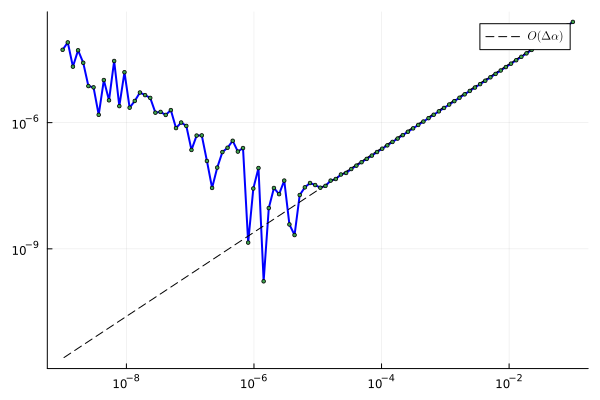

In [131]:
fd_err = fd_error(x->j₂(x; p=5), dj₂, α, Δα, rand(1:prod(N)));

plt1 = Plots.plot()
Plots.plot!(plt1, Δα, fd_err, xaxis=:log10, yaxis=:log10, 
                            label="", lw=2, lc=:blue)
Plots.plot!(plt1, Δα, fd_err[1]/Δα[1]*Δα, label="\$ O(Δα) \$", 
                            lc=:black, ls=:dash)
Plots.scatter!(plt1, Δα, fd_err, label="", markersize=2)

## Example 4:

As a final example, we consider the standard elastic compliance problem on the same geometry.

In [156]:
reffe = ReferenceFE(lagrangian, VectorValue{2,Float64}, 1)

W = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags=["tag_8"]);
V = TrialFESpace(V, VectorValue{2,Float64}(0.0, 0.0))

W′ = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags=["tag_8"], 
                  vector_type=Vector{Dual128});
V′ = TrialFESpace(W′, VectorValue{2,Dual128}(0.0, 0.0))

const E = 70.0
const ν = 0.33
const λₑ = (E*ν)/((1+ν)*(1-2*ν))
const μₑ = E/(2*(1+ν))

σₑ(ε) = λₑ*tr(ε)*one(ε) + 2*μₑ*ε

σₑ (generic function with 1 method)

In [ ]:
f(x) = VectorValue(0.0, -1.0);

# Definition of weak formulation and the energy:
εₑ = Gridap.ε;

a(u,v,ρ) = ∫( (εₑ(v) ⊙ (σ∘εₑ(u)))*ρ )dΩ
l(v,ρ) = ∫(f⋅v)dΩ;

j(u,ρ) = ∫(f⋅u)dΩ;

"""
A complicated objective function...
"""
j₃(α::AbstractVector{T}; p=3) where T<:Real = j( xᵖ( W₁(α); p=p ) );

In [154]:
dj₃, = Zygote.gradient(x->j₃(x; p=5), α);

# Check against finite difference solution
fd_err = fd_error(x->j₃(x; p=5), dj₃, α, Δα, rand(1:prod(N)));

Picked up _j∇j.
Picked up W₁ᵀ.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


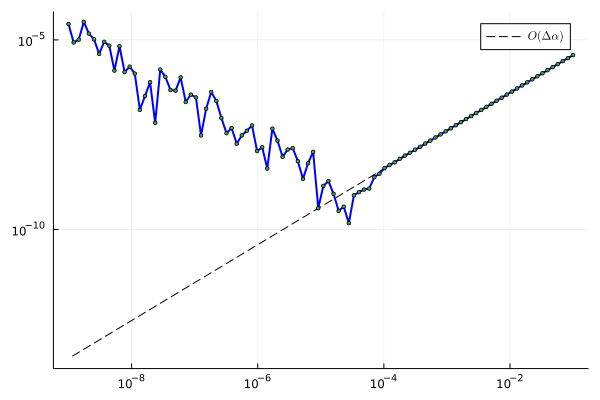

In [155]:
plt1 = Plots.plot()
Plots.plot!(plt1, Δα, fd_err, xaxis=:log10, yaxis=:log10, 
                            label="", lw=2, lc=:blue)
Plots.plot!(plt1, Δα, fd_err[1]/Δα[1]*Δα, label="\$ O(Δα) \$", 
                            lc=:black, ls=:dash)
Plots.scatter!(plt1, Δα, fd_err, label="", markersize=2)

## Conclusion

1. Gradient of objective function w.r.t design variables using adjoint method.
2. Use Forward Mode to compute the partial derivatives. 
    - This gives us the adjoint problem and the element-wise inner products.
3. Export the adjoint method as a Reverse Mode AD rule.
4. Verify the results using finite difference rules.

 To view this notebook, visit [https://github.com/Balaje/TopOpt-Presentation](https://github.com/Balaje/TopOpt-Presentation) or scan:

![QR-Repo](./repo.png)
--